In [1113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import MultinomialNB, GaussianNB


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix ,classification_report, accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score

from sklearn.impute import SimpleImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

import pandas_profiling

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
import plotly.tools as tls

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from yellowbrick.classifier import DiscriminationThreshold
# from yellowbrick.classifier import DiscriminationThreshold

In [656]:
df_churn = pd.read_csv('Telco-Customer-Churn.csv')

In [657]:
df_churn;

#### Dropping "CustomerID" as it provides no signal

In [658]:
df_churn.drop(['customerID'], axis=1, inplace=True)

#### Replacing empty spaces with null values in "TotalCharges"

In [659]:
df_churn['TotalCharges'] = df_churn["TotalCharges"].replace(" " , np.nan)

#### Dropping nulls from "TotalCharges" 

In [660]:
df_churn = df_churn[df_churn["TotalCharges"].notnull()]
df_churn = df_churn.reset_index()[df_churn.columns]

#### Converting strings to floats in "TotalCharges"

In [661]:
df_churn["TotalCharges"] = df_churn["TotalCharges"].astype(float)

#### replacing 'No internet service' to 'No' for columns which show 'No internet service'

Making it more consistent, logically sound

In [662]:
replace_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_columns : 
    df_churn[i]  = df_churn[i].replace({'No internet service' : 'No'})

In [663]:
'''

''';
    
# #replace values
# df_churn["SeniorCitizen"] = df_churn["SeniorCitizen"].replace({1:"Yes",0:"No"})


### Function to bin tenures

I might come back to this and rebin later. Especially curious about more bins to differntiate users with less than 2 years further.

In [664]:
def bin_tenure(df_churn):
    
    '''
    helper function to be able to come back later and change bins
    '''
    
    if df_churn["tenure"] <= 12 :
        return "Tenure_0_to_12"
    elif (df_churn["tenure"] > 12) & (df_churn["tenure"] <= 24 ):
        return "Tenure_12_to_24"
    elif (df_churn["tenure"] > 24) & (df_churn["tenure"] <= 48) :
        return "Tenure_24_to_48"
    elif (df_churn["tenure"] > 48) & (df_churn["tenure"] <= 60) :
        return "Tenure_48_to_60"
    elif df_churn["tenure"] > 60 :
        return "Tenure_60+"

### binning tenure 

In [665]:
df_churn["tenure_bin"] = df_churn.apply(lambda df_churn:bin_tenure(df_churn), axis = 1)

In [666]:
# cat_cols   = df_churn.nunique()[df_churn.nunique() <= 5].keys().tolist()
# cat_cols;

In [667]:
# Separating churn and non-churn
df_only_churn     = df_churn[df_churn["Churn"] == "Yes"]
df_not_churn = df_churn[df_churn["Churn"] == "No"]

# Separating columns by numerical and categorical, target column is "Churn"
target_col = ["Churn"]

cat_cols   = df_churn.nunique()
cat_cols   = df_churn.nunique()[df_churn.nunique() <= 5].keys().tolist()
cat_cols   = [col for col in cat_cols if col not in target_col]
num_cols   = [col for col in df_churn.columns if col not in cat_cols + target_col]


# get binary columns with 2 values
bin_cols   = df_churn.nunique()[df_churn.nunique() == 2].keys().tolist()
# get columns with more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [668]:
df_churn;

In [669]:

# df_scaled.to_pickle("./df_churn.pkl")


In [670]:
# df_churn_scaled = df_churn.drop(columns = num_cols,axis = 1)
# df_churn_scaled = df_churn_scaled.merge(df_scaled,left_index=True,right_index=True,how = "left")

In [671]:
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_0_to_12
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_24_to_48
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_0_to_12
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_24_to_48
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_0_to_12


### One Hot Encoding

In [672]:
df_churn_encoded = pd.get_dummies(data = df_churn,columns = multi_cols, drop_first = True )


In [673]:
df_churn_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bin_Tenure_12_to_24,tenure_bin_Tenure_24_to_48,tenure_bin_Tenure_48_to_60,tenure_bin_Tenure_60+
0,Female,0,Yes,No,1,No,No,Yes,No,No,...,0,0,0,0,1,0,0,0,0,0
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,...,0,1,0,0,0,1,0,1,0,0
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,...,0,0,0,0,0,1,0,0,0,0
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,...,0,1,0,0,0,0,0,1,0,0
4,Female,0,No,No,2,Yes,No,No,No,No,...,0,0,0,0,1,0,0,0,0,0


In [674]:
df_churn_encoded = pd.get_dummies(data = df_churn_encoded,columns = bin_cols, drop_first = True )

In [675]:
df_churn_encoded.head();

In [676]:
df_churn_encoded.head();

In [677]:

# df_churn_scaled.to_pickle("./df_churn_scaled_with_1_hot_encoding.pkl")


In [678]:
# df_churn_scaled = pd.read_pickle("./df_churn_scaled_with_1_hot_encoding.pkl")

In [679]:
df_churn_encoded.head();
df_churn_encoded.isnull().values.any();

## Model

### Train Test Validation Split

In [900]:
target_col = ["Churn_Yes"]
ys = df_churn_encoded["Churn_Yes"]

train_val , test = train_test_split(df_churn_encoded,test_size = .20 ,random_state = 1988, stratify = ys)
train , val = train_test_split(train_val, test_size = .20 ,random_state = 2014, stratify = train_val[target_col])

In [898]:
# target_col = ["Churn_Yes"]
# ys = df_churn_encoded["Churn_Yes"]

# train_val , test = train_test_split(df_churn_encoded,test_size = .20 ,random_state = 1988)
# train , val = train_test_split(train_val, test_size = .20 ,random_state = 2014,)

In [899]:
target_col = ["Churn_Yes"]

cols    = [i for i in df_churn_encoded.columns if i not in target_col]

'''
train_val_X and _Y are used for cross validation.

train_X is a subset of train_val_X

test_X and test_Y are the holdout sets


'''

train_val_X = train_val[cols]
train_val_Y = train_val[target_col]
train_X = train[cols]
train_Y = train[target_col]
val_X = val[cols]
val_Y = val[target_col]
test_X  = test[cols]
test_Y  = test[target_col]


In [732]:
val_Y.head()

,Churn_Yes
4484,0
2748,1
1665,1
3599,0
5971,0


### Standardizing
Standardizing the columns with numerical data, i.e. 'tenure', 'MonthlyCharges', 'TotalCharges'

In [704]:
std = StandardScaler()


In [901]:
std.fit(train_val_X[num_cols])
test_X[num_cols] = std.transform(test_X[num_cols])
train_val_X[num_cols] = std.transform(train_val_X[num_cols])


In [902]:
std.fit(train_X[num_cols])
val_X[num_cols] = std.transform(val_X[num_cols])
train_X[num_cols] = std.transform(train_X[num_cols])

In [1022]:
complete = df_churn_encoded.copy()

In [1024]:
std.fit(complete[num_cols])
std.transform(complete[num_cols])

array([[-1.28024804, -1.16169394, -0.99419409],
       [ 0.06430269, -0.26087792, -0.17373982],
       [-1.23950408, -0.36392329, -0.95964911],
       ...,
       [-0.87280842, -1.17000405, -0.85451414],
       [-1.15801615,  0.31916782, -0.87209546],
       [ 1.36810945,  1.35793167,  2.01234407]])

#### Function to show ROC

In [259]:
def plot_roc(test_y, preds, probs):
    '''
    plots ROC and prints out AUC
    '''
    model_roc_auc = roc_auc_score(test_y, preds) 
    print ("Area under curve : ",model_roc_auc,"\n")

    fpr, tpr, thresholds = roc_curve(test_y, probs[:,1])

    plt.plot(fpr, tpr, lw = 2)
    plt.plot([0,1],[0,1], c='violet', ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');

#### Function to show roc for a list of models for comparison

In [1102]:
def plot_comparison_roc(model_dict, test_x = val_X , test_y = val_Y,
                       ):
    
    '''
    INPUT: dict of trained models, test df
    
    plots the overlaying roc curves  for comparison purposes.     
    '''
    
    colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
    'black',
    'violet',
    ]
    
    i = 0
    
    fig = plt.figure(figsize=(14,14))
    
    for key, model in model_dict.items():
        color = colors[i]
        i += 1
        i = i % len(colors)
        predictions   = model.predict(test_x)  
        probabilities = model.predict_proba(test_x)
        fpr, tpr, thresholds = roc_curve(test_y, probabilities[:,1])
        plt.plot(fpr, tpr, lw = 2, label= key, c = color)
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
    
    plt.plot([0,1],[0,1], c = 'black', ls='--')
    plt.xlabel('False Positive Rate',fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('ROC Curves', fontsize = 20)
    plt.legend(loc="lower right", fontsize = 20)
    plt.tight_layout()
    
    plt.show()
        

#### Function to make predictions and return ROC AUC

In [260]:
def get_model_ROC_AUC(algorithm, test_x, test_y):
    '''
    Input is a model that has been .fit(), and the dfs for test_x and test_y
    
    returns ROC AUC
    '''
    
    predictions   = algorithm.predict(test_x)
    probabilities = algorithm.predict_proba(test_x)
    model_roc_auc = roc_auc_score(test_y, predictions)
    return model_roc_auc

#### Function to compare baseline models

In [911]:
def get_baseline_models_AUCs(train_x = train_X, test_x = val_X,
                            train_y = train_Y, test_y = val_Y):
    '''
    This function prints out the AUCs for all baseline models.
    It returns a dict with all the models as keys, and the AUCs as values.
    '''
    result = {}
    models = {"Logistic Regression" : LogisticRegression(), 
              "KNN" : KNeighborsClassifier(n_neighbors = 6),
              "Support Vector Classifier" : SVC(probability=True),
              "Random Forest": RandomForestClassifier(random_state= 31),
              "Gaussian Naive Bayes" : GaussianNB(),
#               "Multinomial Naive Bayes" : MultinomialNB(),
              "Gradient Boost Classifier" : GradientBoostingClassifier(),
              "Light GBM Classifier" : LGBMClassifier(),
#               "XGBoost Classifier" : XGBClassifier()
              
             }
    
    for key, algorithm in models.items():
        if  key == "XGBoost Classifier":
            test_x = test_x.as_matrix()
            test_y = test_y.as_matrix()
        fit_model = algorithm.fit(train_x, train_y)
        model_roc_auc = get_model_ROC_AUC(fit_model, test_x, test_y)
        print (f'{key} :  {model_roc_auc}\n')
        result[key] = [model_roc_auc, algorithm]
    
    return result

In [912]:
type(val_Y)

pandas.core.frame.DataFrame

In [913]:
get_baseline_models_AUCs()

Logistic Regression :  0.701724124594881

KNN :  0.6551325386941825

Support Vector Classifier :  0.6595221336138549

Random Forest :  0.6458389734149115

Gaussian Naive Bayes :  0.7630121516363327

Gradient Boost Classifier :  0.6955129444706574

Light GBM Classifier :  0.6908390894394467



{'Logistic Regression': [0.701724124594881,
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False)],
 'KNN': [0.6551325386941825,
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=6, p=2,
             weights='uniform')],
 'Support Vector Classifier': [0.6595221336138549,
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)],
 'Random Forest': [0.6458389734149115,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes

### Correlation Matrix

In [291]:
def make_correlation_matrix(df = df_churn):   
    '''
    produces a plotly correlation matrix
    
    INPUT: dataframe
    
    RETURNS: the plotly plot.
    
    NOTE: you need to store the output of this function in a cariable, 
    and then put that in a new line to see the plot.
    like so:

    out = make_correlation_matrix(df_churn_scaled)
    out
    
    '''
    correlations = df.corr()
    matrix_columns = correlations.columns.tolist()
    corr_array  = np.array(correlations)

    
    heat = go.Heatmap(z = corr_array,
                        x = matrix_columns,
                        y = matrix_columns,
                        colorscale = "Jet",
                        colorbar   = dict(title = "Pearson correlation coefficient",
                                         titleside = "right"
                                        ) ,
                      )

    layout = go.Layout(dict(title = "Correlation Matrix",
                            
                            height  = 600,
                            width   = 800,
                            margin  = dict(r = 0 ,l = 200,
                                           t = 25,b = 200,
                                          ),
                            yaxis   = dict(tickfont = dict(size = 10)),
                            xaxis   = dict(tickfont = dict(size = 10))
                           )
                      )

    fig = go.Figure(data= [heat],layout=layout)
    return py.iplot(fig, filename = 'correlation-matrix')

In [914]:
out = make_correlation_matrix(df_churn_scaled)
out

### Function for Model report

In [967]:
def produce_model_report(model,train_x,test_x,train_y,test_y,name) :
    model.fit(train_x,train_y)
    predictions  = model.predict(test_x)
    accuracy     = accuracy_score(test_y,predictions)
    recallscore  = recall_score(test_y,predictions)
    precision    = precision_score(test_y,predictions)
    roc_auc      = roc_auc_score(test_y,predictions)
    f1score      = f1_score(test_y,predictions) 
    kappa_metric = cohen_kappa_score(test_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

## Model Pipeline

In [1129]:
def make_model_prediction_coefs(cols, cf, algorithm = LogisticRegression(), 
                                train_x = train_X , test_x = val_X ,
                                train_y = train_Y ,test_y = val_Y, 
                                threshold_plot = True,
                               
                               ) :
    
    '''
    This function fits the model, prints a summary including AUC curve, accuracy score, F1 score
    It also produces 3 plotly graphs: A confusion matrix, an ROC curve, and a bar graph showing
    feature importance for each feature.
    
    INPUT:
    It takes columns, algorithm, train_df for x and y, test_df for x and y bas inputs
    
    cf is an input string that is either "coefficients" or "features"
    
    RETURNS: A tuple of (model, pyplot object)
    
    DEFAULT:
    Its default algorithm is LogisticRegression()
    default train dfs are train_X and train_Y
    default test dfs are val_X and val_Y
    
    NOTE: you need to store the output of this function in a variable, 
    and then put that in a new line to see the plot.
    like so:
    
    (logit_model, logit_graph) = make_model_prediction_coefs(cols = cols, cf = "coefficients")
    logit_graph
    '''
    
    
    algorithm.fit(train_x, train_y)
    
    predictions   = algorithm.predict(test_x)  
    probabilities = algorithm.predict_proba(test_x)

    fpr, tpr, thresholds = roc_curve(test_y, probabilities[:,1])
    
    if   cf == "coefficients":
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features":
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df       = pd.DataFrame(cols)
    coef_summary    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_summary.columns = ["coefficients","features"]
    coef_summary    = coef_summary.sort_values(by = "coefficients",ascending = False)
    
    print("_____________________________________________________________")   
    print("\n Results : \n", classification_report(test_y,predictions))
    print("Accuracy - score : ", accuracy_score(test_y,predictions))
    
    
    conf_matrix = confusion_matrix(test_y,predictions)
    
    

    # making roc curve, redundant
#     plot_roc(test_y, preds = predictions, probs = probabilities)
    
    # this can be commented out if using non-plotly roc curve above: plot_roc()
    
    model_roc_auc = roc_auc_score(test_y, predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'),
                            print_grid=False)
    
    
    
    bars = go.Bar(x = coef_summary["features"], y = coef_summary["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_summary["coefficients"],
                                  colorscale = "Jet",
                                  line = dict(width = .6, color = "black")))
    
    roc_line = go.Scatter(x = fpr, y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(25, 96, 167)'),width = 2))
    
    roc_stand = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(215, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    c_matrix = go.Heatmap(z = conf_matrix ,
                        x = ["Non churn","Churn"],
                        y = ["Non churn","Churn"],
                        showscale  = False, colorscale = "Jet",
                        name = "matrix")
    
    
    
    
    fig.append_trace(bars,2,1)
    fig.append_trace(roc_line,1,2)
    fig.append_trace(c_matrix,1,1)
    fig.append_trace(roc_stand,1,2)
    
    fig['layout'].update(showlegend = False, title="Model performance" ,
                         autosize = False,height = 1000,width = 850,
                         plot_bgcolor = 'rgba(250,250,250, 0.95)',
                         paper_bgcolor = 'rgba(250,250,250, 0.95)',
                         margin = dict(b = 185))
    
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis1"].update(dict(showgrid = True,tickfont = dict(size = 12),
                                        tickangle = 0))
#     print('\nConfusion Matrix:')
#     print(conf_matrix)

    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm, size=(1280, 1080))
        visualizer.fit(train_x, train_y)
        
        plt.xlabel('Discrimination Threshold',fontsize = 20)
        plt.ylabel('Score', fontsize = 20)
        plt.title(f'Threshold Plot for {algorithm}', fontsize = 20)
        plt.legend(loc="lower right", fontsize = 20)
    
        visualizer.poof()
        
    return(algorithm, py.iplot(fig, filename = 'jupyter-table1'))


_____________________________________________________________

 Results : 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       803
           1       0.65      0.52      0.57       322

   micro avg       0.78      0.78      0.78      1125
   macro avg       0.73      0.70      0.71      1125
weighted avg       0.77      0.78      0.77      1125

Accuracy - score :  0.7813333333333333
Area under curve :  0.701724124594881 



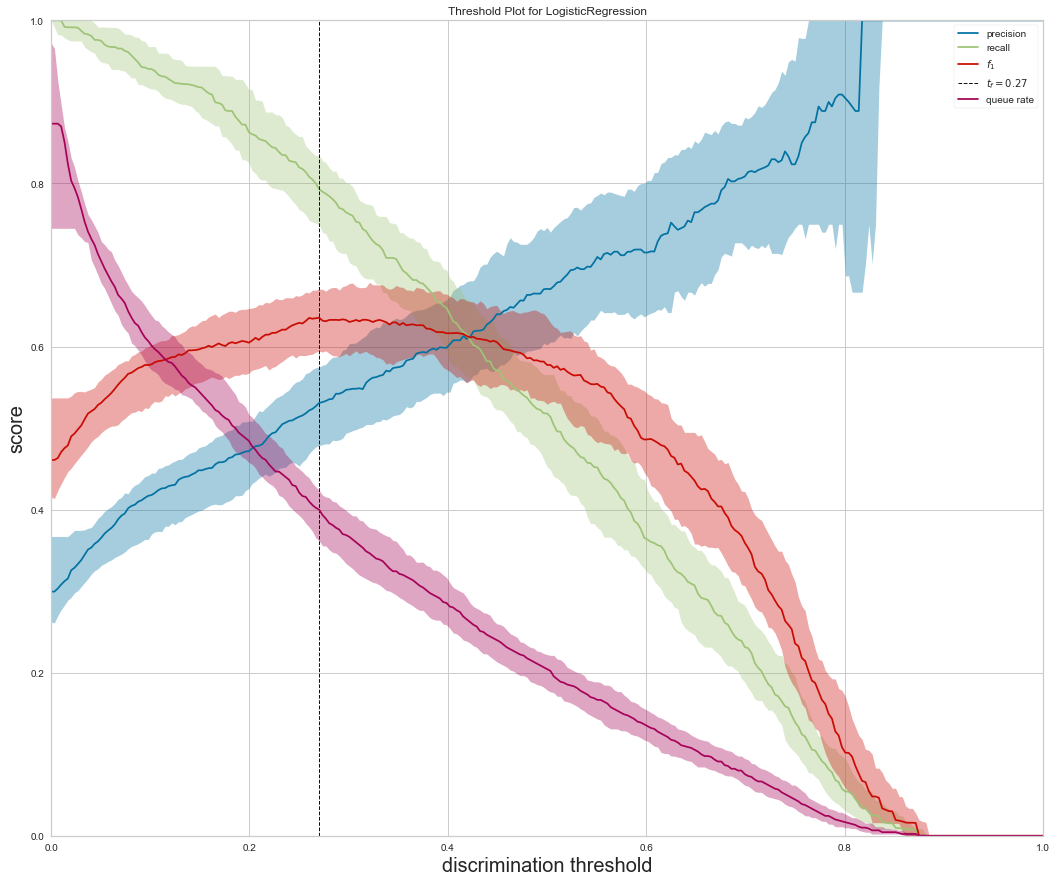

In [1130]:
(logit_model, logit_graph) = make_model_prediction_coefs(cols = cols, cf = "coefficients")
logit_graph

In [1021]:
important_features = ['Contract_Two year',
                      'tenure', 'PhoneService_Yes',
                      'Contract_One year', 'tenure_bin_Tenure_60+', 'Churn_Yes']

## KNN

In [722]:
knn = KNeighborsClassifier(algorithm = 'auto', leaf_size=30,
           metric_params = None, n_jobs=-1, n_neighbors = 6, p = 2,
           weights='uniform')

In [723]:
knn.fit(train_X,train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
           weights='uniform')

In [724]:
predictions_knn   = knn.predict(val_X)
probabilities_knn = knn.predict_proba(val_X)

In [725]:
print("\n Classification report: \n",classification_report(val_Y ,predictions_knn))
print("Accuracy Score: ",accuracy_score(val_Y ,predictions_knn))


 Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.93      0.84       803
           1       0.64      0.33      0.44       322

   micro avg       0.76      0.76      0.76      1125
   macro avg       0.71      0.63      0.64      1125
weighted avg       0.74      0.76      0.73      1125

Accuracy Score:  0.7564444444444445


Area under curve :  0.6294118329556091 



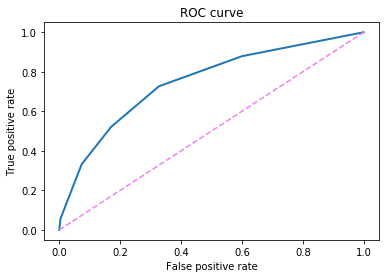

In [728]:
plot_roc(test_y = val_Y, preds = predictions_knn, probs = probabilities_knn)

## Random Forest

In [ ]:
forest = RandomForestClassifier()

## SMOTE

In [936]:
train_X_SMOTE, train_Y_SMOTE = SMOTE(random_state = 1911).fit_sample(train_X, train_Y)
train_val_X_SMOTE, train_val_Y_SMOTE = SMOTE(random_state = 1911).fit_sample(train_val_X, train_val_Y)
val_X_SMOTE, val_Y_SMOTE = SMOTE(random_state = 1911).fit_sample(val_X, val_Y)

In [1020]:
# (logit_model_smote, logit_graph_smote) = make_model_prediction_coefs(cols = cols, cf = "coefficients", 
#                                                                      train_x =train_X_SMOTE, train_y = train_Y_SMOTE, 
#                                                                      test_x = val_X, test_y = val_Y)
# logit_graph_smote

In [714]:
get_baseline_models_AUCs(train_x = train_X_SMOTE, test_x = val_X_SMOTE,
                            train_y = train_Y_SMOTE, test_y = val_Y_SMOTE)

Logistic Regression :  0.765255292652553

KNN :  0.6930261519302615

Support Vector Classifier :  0.6488169364881694

Random Forest :  0.8212951432129514

Gaussian Naive Bayes :  0.7889165628891656

Gradient Boost Classifier :  0.8449564134495641

Light GBM Classifier :  0.8306351183063513

XGBoost Classifier :  0.8480697384806973



{'Logistic Regression': 0.765255292652553,
 'KNN': 0.6930261519302615,
 'Support Vector Classifier': 0.6488169364881694,
 'Random Forest': 0.8212951432129514,
 'Gaussian Naive Bayes': 0.7889165628891656,
 'Gradient Boost Classifier': 0.8449564134495641,
 'Light GBM Classifier': 0.8306351183063513,
 'XGBoost Classifier': 0.8480697384806973}

SMOTE lead to an increased performance. 

## ADASYN

In [733]:
train_X_ADASYN, train_Y_ADASYN = ADASYN(random_state = 1911).fit_sample(train_X, train_Y)
train_val_X_ADASYN, train_val_Y_ADASYN = ADASYN(random_state = 1911).fit_sample(train_val_X, train_val_Y)
# val_X_ADASYN, val_Y_ADASYN = ADASYN(random_state = 1911).fit_sample(val_X, val_Y)

In [1019]:
# (logit_model_adasyn, logit_graph_adasyn) = make_model_prediction_coefs(cols = cols, cf = "coefficients", 
#                                                                      train_x = train_X_ADASYN, train_y = train_Y_ADASYN, 
#                                                                      test_x = val_X, test_y = val_Y)
# logit_graph_adasyn

In [760]:
get_baseline_models_AUCs(train_x = train_X_ADASYN, test_x = val_X,
                            train_y = train_Y_ADASYN, test_y = val_Y)

Logistic Regression :  0.7474145866045807

KNN :  0.6862870601703239

Support Vector Classifier :  0.6556546491031303

Random Forest :  0.654809603737537

Gaussian Naive Bayes :  0.7626660117726229

Gradient Boost Classifier :  0.7187739300604102

Light GBM Classifier :  0.6877102944702707

XGBoost Classifier :  0.718458730072786



{'Logistic Regression': [0.7474145866045807,
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False)],
 'KNN': [0.6862870601703239,
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=6, p=2,
             weights='uniform')],
 'Support Vector Classifier': [0.6556546491031303,
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)],
 'Random Forest': [0.654809603737537,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes

ADASYN does a tiny bit better than SMOTE.

### Grid Search     

noticed the issue with crossvalidating on upsampled (SMOTED) data. --- will remedy it.
bad params to start with. 

In [302]:
parameter_grid={
#     "loss":["deviance"],
    "learning_rate": [0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.01, 0.1, 6),
    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    "max_depth":[3,5,7],
    "max_features":["sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
    "subsample":[ 1.0],
    "n_estimators":[125]
    }
clf = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'roc_auc', verbose= True)
clf.fit(train_X_SMOTE, train_Y_SMOTE)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 91.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.05, 0.075, 0.1], 'min_samples_split': array([0.01 , 0.028, 0.046, 0.064, 0.082, 0.1  ]), 'min_samples_leaf': array([0.1 , 0.18, 0.26, 0.34, 0.42, 0.5 ]), 'max_depth': [10, 20], 'max_features': ['sqrt'], 'criterion': ['friedman_mse', 'mae'], 'subsample': [1.0], 'n_estimators': [125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [303]:
# clf.best_score_

0.9045428039465869

ROC_AUC is 0.9045428039465869

In [305]:
# clf_best_params = clf.best_params_

In [306]:
# clf_best_params

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.082,
 'n_estimators': 125,
 'subsample': 1.0}

AttributeError: 'GridSearchCV' object has no attribute 'to_pickle'

GradientBoostClassifier() performs best at

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.082,
 'n_estimators': 125,
 'subsample': 1.0}


### Grid Search V2

horrible params.

In [805]:
parameter_grid={
#     "loss":["deviance"],
    "learning_rate": [0.05, 0.075, 0.1],
    #'min_samples_leaf': [1, 2],
    #'min_samples_split': [2, 3],
    "max_depth":[3,5,7,9,11,15],
#     "max_features":["sqrt"],
#     "criterion": ["friedman_mse"],
#     "subsample": [ 1.0],
    "n_estimators": [150, 300, 500, 700, 1500],
#     'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:10}]
    }
clf = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'roc_auc', verbose= True)

clf.fit(train_X, train_Y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 14.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.05, 0.075, 0.1], 'max_depth': [3, 5, 7, 9, 11, 15], 'criterion': ['friedman_mse'], 'n_estimators': [150, 300, 500, 700, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [ ]:
# clf.fit(train_X, val_X)

In [806]:
clf_best_params = clf.best_params_

In [807]:
clf_best_params

{'criterion': 'friedman_mse',
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 150}

best params were:
{'criterion': 'friedman_mse',
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 150}
 
 time for another grid search with better params!

In [890]:
parameter_grid = {
#     "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05],
    #'min_samples_leaf': [1, 2],
    #'min_samples_split': [2, 3],
    "max_depth":[2,3,4,5,6],
#     "max_features":["sqrt"],
#     "criterion": ["friedman_mse"],
#     "subsample": [ 1.0],
    "n_estimators": [100, 125, 150, 175],
#     'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:4},{0:1,1:6},{0:1,1:10}]
    }
clf2 = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'roc_auc', verbose= True)

clf2.fit(train_X, train_Y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   54.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.025, 0.05], 'max_depth': [2, 3, 4, 5, 6], 'n_estimators': [100, 125, 150, 175]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [817]:
clf2_best_params = clf2.best_params_

In [818]:
clf2_best_params

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 125}

### Grid Search for XGBoost 

In [336]:
params_xgboost = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        'n_estimators' : [150, 300, 500, 700, 1500]
        }

In [337]:
xgb = XGBClassifier(learning_rate=0.02,  objective='binary:logistic',
                    silent=True, nthread=1)

In [341]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 1001)

In [718]:
random_search = RandomizedSearchCV(xgb, param_distributions = params_xgboost, 
                                   n_iter = param_comb, scoring = 'roc_auc', 
                                   n_jobs = -1, cv = skf.split(train_val_X, test_X), verbose=3, 
                                   random_state = 2000 )

In [719]:
random_search

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x1a27fa3840>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=125,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=2000, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [746]:


random_seed = 123
kf = StratifiedKFold(n_splits=5, random_state=random_seed)
cross_val_f1_score_lst = []
cross_val_accuracy_lst = []
cross_val_recall_lst = []
cross_val_precision_lst = []

for train_index_ls, validation_index_ls in kf.split(x_train, y_train):
    # keeping validation set apart and oversampling in each iteration using smote 
    train, validation = x_train.iloc[train_index_ls], x_train.iloc[validation_index_ls]
    target_train, target_val = y_train.iloc[train_index_ls], y_train.iloc[validation_index_ls]
    sm = SMOTE(random_state=random_seed)
    X_train_res, y_train_res = sm.fit_sample(train, target_train)
    print (X_train_res.shape, y_train_res.shape)

    # training the model on oversampled 4 folds of training set
    rf = RandomForestClassifier(n_estimators=5, random_state=random_seed)
    rf.fit(X_train_res, y_train_res)

    # testing on 1 fold of validation set
    validation_preds = rf.predict(validation)
    cross_val_recall_lst.append(recall_score(target_val, validation_preds))
    cross_val_accuracy_lst.append(accuracy_score(target_val, validation_preds))
    cross_val_precision_lst.append(precision_score(target_val, validation_preds))
    cross_val_f1_score_lst.append(f1_score(target_val, validation_preds))

print ('Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst)))
print ('Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst)))
print ('Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst)))
print ('Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst)))

NameError: name 'x_train' is not defined

In [790]:
gbc = GradientBoostingClassifier(criterion= 'friedman_mse',
 learning_rate= 0.1,
 loss= 'deviance',
 max_depth= 10,
 max_features= 'sqrt',
 min_samples_leaf= 0.1,
 min_samples_split= 0.082,
 n_estimators= 125,
 subsample= 1.0)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.082,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [792]:
f1_score(train_Y_ADASYN ,gbc.predict(train_X_ADASYN))

0.8656488549618321

0.845605700712589

0.6181318681318683

0.8673175629100935

0.8428583986521135

0.737984496124031

In [830]:
gbc = GradientBoostingClassifier(criterion= 'friedman_mse',
 learning_rate= 0.05,
 max_depth= 3,
 n_estimators= 150)

gbc.fit(train_val_X, train_val_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [831]:
gbc2 = GradientBoostingClassifier(criterion = 'friedman_mse',
 learning_rate= 0.05,
 max_depth= 2,
 n_estimators= 125)

gbc2.fit(train_val_X, train_val_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=125,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [832]:
roc_auc_score(test_Y ,gbc.predict(test_X))

0.704515503875969

In [833]:
roc_auc_score(test_Y ,gbc2.predict(test_X))

0.6971201550387597

In [836]:
nbg = GaussianNB()

In [838]:
nbg.fit(train_val_X, train_val_Y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [839]:
roc_auc_score(test_Y ,nbg.predict(test_X))

0.7398527131782946

### Light GBM 

In [843]:
params_LGBM = {'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.2],
              'n_estimators' : [50, 75, 100, 125],
              'num_leaves': [10, 15, 20, 25], 
              'min_child_samples': [50, 75, 100, 125], 
              'min_child_weight': [ 1, 10, 100, 1000],
#               'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50, 100],
              }

n_iter = 1000
seed = 101



In [847]:
lgbm = LGBMClassifier(random_state=seed, silent=False, metric='None', n_jobs=-1)
grid_search = RandomizedSearchCV(
    estimator=lgbm, param_distributions=params_LGBM, 
#     n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state= seed,
    verbose=True)



grid_search.fit(train_val_X, train_val_Y)
print('Best params: {} '.format(grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best params: {'colsample_bytree': 0.9867471459313902, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 100, 'min_child_weight': 1, 'n_estimators': 125, 'num_leaves': 25, 'reg_alpha': 50, 'reg_lambda': 0} 


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.0s finished


best params first grid search were

{'colsample_bytree': 0.9867471459313902, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 100, 'min_child_weight': 1, 'n_estimators': 125, 'num_leaves': 25, 'reg_alpha': 50, 'reg_lambda': 0} 

In [891]:
lgbm1 = LGBMClassifier(colsample_bytree= 0.9867471459313902, 
                        learning_rate= 0.1, 
                        max_depth= 7, 
                        min_child_samples= 100, 
                        min_child_weight= 1, 
                        n_estimators= 125, 
                        num_leaves= 25, 
                        reg_alpha= 50, 
                        reg_lambda= 0)

lgbm1.fit(train_val_X, train_val_Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9867471459313902, importance_type='split',
        learning_rate=0.1, max_depth=7, min_child_samples=100,
        min_child_weight=1, min_split_gain=0.0, n_estimators=125,
        n_jobs=-1, num_leaves=25, objective=None, random_state=None,
        reg_alpha=50, reg_lambda=0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [892]:
roc_auc_score(test_Y ,lgbm1.predict(test_X))

0.6744534883720931

In [896]:
nbc = GaussianNB().fit(train_val_X, train_val_Y)

In [897]:
roc_auc_score(test_Y ,nbc.predict(test_X))

0.7398527131782946

In [953]:
nbc2 = GaussianNB().fit(train_val_X_SMOTE, train_val_Y_SMOTE)

In [954]:
roc_auc_score(test_Y ,nbc2.predict(test_X))

0.740220930232558

In [955]:
nbc3 = GaussianNB().fit(train_X_SMOTE, train_Y_SMOTE)

In [956]:
roc_auc_score(val_Y_SMOTE ,nbc3.predict(val_X_SMOTE))

0.7714819427148194

In [927]:
xgb =  XGBClassifier(subsample= 1.0, 
                     min_child_weight= 5, 
                     max_depth= 5, gamma= 5, 
                     colsample_bytree= 0.6, 
                     n_estimators = 100,
                    )

In [928]:
xgb.fit(train_val_X, train_val_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [929]:
roc_auc_score(test_Y ,xgb.predict(test_X))

0.7014883720930234

In [940]:
xgb2 =  XGBClassifier(subsample= 1.0, 
                     min_child_weight= 5, 
                     max_depth= 5, gamma= 5, 
                     colsample_bytree= 0.6, 
                     n_estimators = 100,
                    )

In [973]:
xgb2.fit(train_X_SMOTE, train_Y_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [978]:
roc_auc_score(val_Y_SMOTE ,xgb2.predict(val_X_SMOTE))

0.836239103362391

In [963]:
xgb3 =  XGBClassifier(subsample= 1.0, 
                     min_child_weight= 5, 
                     max_depth= 5, gamma= 5, 
                     colsample_bytree= 0.6, 
                     n_estimators = 100,
                    )

In [969]:
xgb3.fit(train_val_X_SMOTE, train_val_Y_SMOTE)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [970]:
roc_auc_score(test_Y.as_matrix() ,xgb3.predict(test_X.as_matrix()))

0.7284186046511628

In [1080]:
kernels =['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [1092]:
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

In [1093]:
svc_lin.fit(train_val_X, train_val_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1094]:
roc_auc_score(test_Y ,svc_lin.predict(test_X))

0.6933604651162791

In [980]:
logit1 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [981]:
logit1.fit(train_val_X, train_val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [982]:
roc_auc_score(test_Y ,logit1.predict(test_X))

0.7161550387596899

## Model Comparision


In [1016]:
models = {"Logistic Regression" : LogisticRegression(C=1.0,
                                                     class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True, 
                                                     intercept_scaling=1,
                                                     multi_class='ovr',
                                                     n_jobs=-1,
                                                     penalty='l2',
                                                     random_state=None,
                                                     solver='liblinear',
                                                     tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False), 
          
              "KNN" : KNeighborsClassifier(n_neighbors = 6),
          
              "Support Vector Classifier" : SVC(C=1.0, 
                                             cache_size=200, 
                                             class_weight=None, 
                                             coef0=0.0,
                                             decision_function_shape='ovr', 
                                             degree=3, gamma=1.0, 
                                             kernel='linear',
                                             max_iter=-1,
                                             probability=True,
                                             random_state=None,
                                             shrinking=True,
               tol=0.001, verbose=False),
              "Random Forest": RandomForestClassifier(random_state= 31,
                                                    max_depth= 7, 
                                                    n_estimators= 125, 
                                                     ),
              "Gaussian Naive Bayes" : GaussianNB(),
#               "Multinomial Naive Bayes" : MultinomialNB(),
              "Gradient Boost Classifier" : GradientBoostingClassifier(),
              "Light GBM Classifier" : LGBMClassifier(colsample_bytree= 0.9867471459313902, 
                                        learning_rate= 0.1, 
                                        max_depth= 7, 
                                        min_child_samples= 100, 
                                        min_child_weight= 1, 
                                        n_estimators= 125, 
                                        num_leaves= 25, 
                                        reg_alpha= 50, 
                                        reg_lambda= 0),
              "XGBoost Classifier" : XGBClassifier(subsample= 1.0, 
                                                     min_child_weight= 5, 
                                                     max_depth= 5, gamma= 5, 
                                                     colsample_bytree= 0.6, 
                                                     n_estimators = 100,
                                                    )
              
             }

# fitting ALL the models !
for key, model in models.items():
    model.fit(train_X, train_Y)

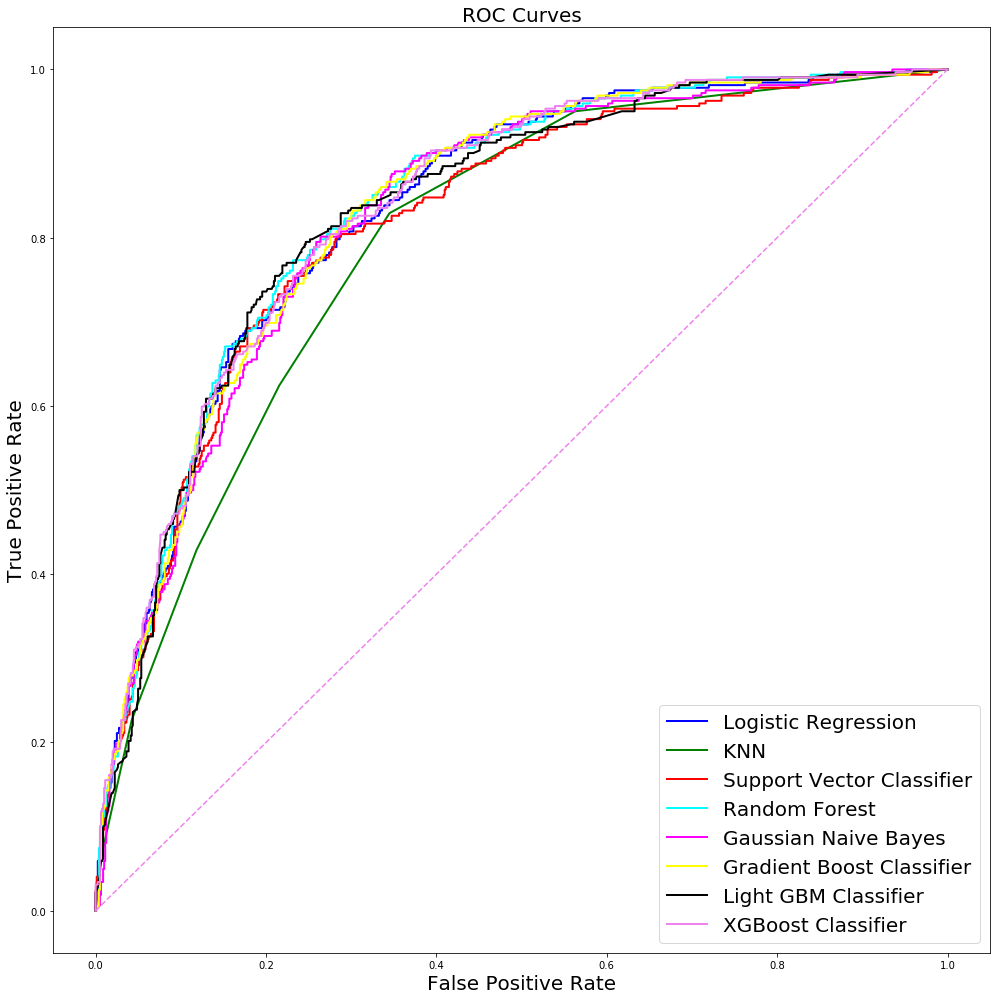

In [1017]:
plot_comparison_roc(models,
#                     train_x = train_X ,
                    test_x = val_X ,
#                     train_y = train_Y ,
                    test_y = val_Y,
                   )

In [1029]:
best_models = {"Logistic Regression" : LogisticRegression(C=1.0,
                                                     class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True, 
                                                     intercept_scaling=1,
                                                     multi_class='ovr',
                                                     n_jobs=-1,
                                                     penalty='l2',
                                                     random_state=None,
                                                     solver='liblinear',
                                                     tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False), 
          
          
              "Support Vector Classifier" : SVC(C=1.0, 
                                             cache_size=200, 
                                             class_weight=None, 
                                             coef0=0.0,
                                             decision_function_shape='ovr', 
                                             degree=3, gamma=1.0, 
                                             kernel='linear',
                                             max_iter=-1,
                                             probability=True,
                                             random_state=None,
                                             shrinking=True,
               tol=0.001, verbose=False),

              "Gaussian Naive Bayes" : GaussianNB(),
#               "Multinomial Naive Bayes" : MultinomialNB(),
              "Light GBM Classifier" : LGBMClassifier(colsample_bytree= 0.9867471459313902, 
                                        learning_rate= 0.1, 
                                        max_depth= 7, 
                                        min_child_samples= 100, 
                                        min_child_weight= 1, 
                                        n_estimators= 125, 
                                        num_leaves= 25, 
                                        reg_alpha= 50, 
                                        reg_lambda= 0),
              "XGBoost Classifier" : XGBClassifier(subsample= 1.0, 
                                                     min_child_weight= 5, 
                                                     max_depth= 5, gamma= 5, 
                                                     colsample_bytree= 0.6, 
                                                     n_estimators = 100,
                                                    )
              
             }

# fitting ALL the models !
for key, model in best_models.items():
    model.fit(train_X, train_Y)

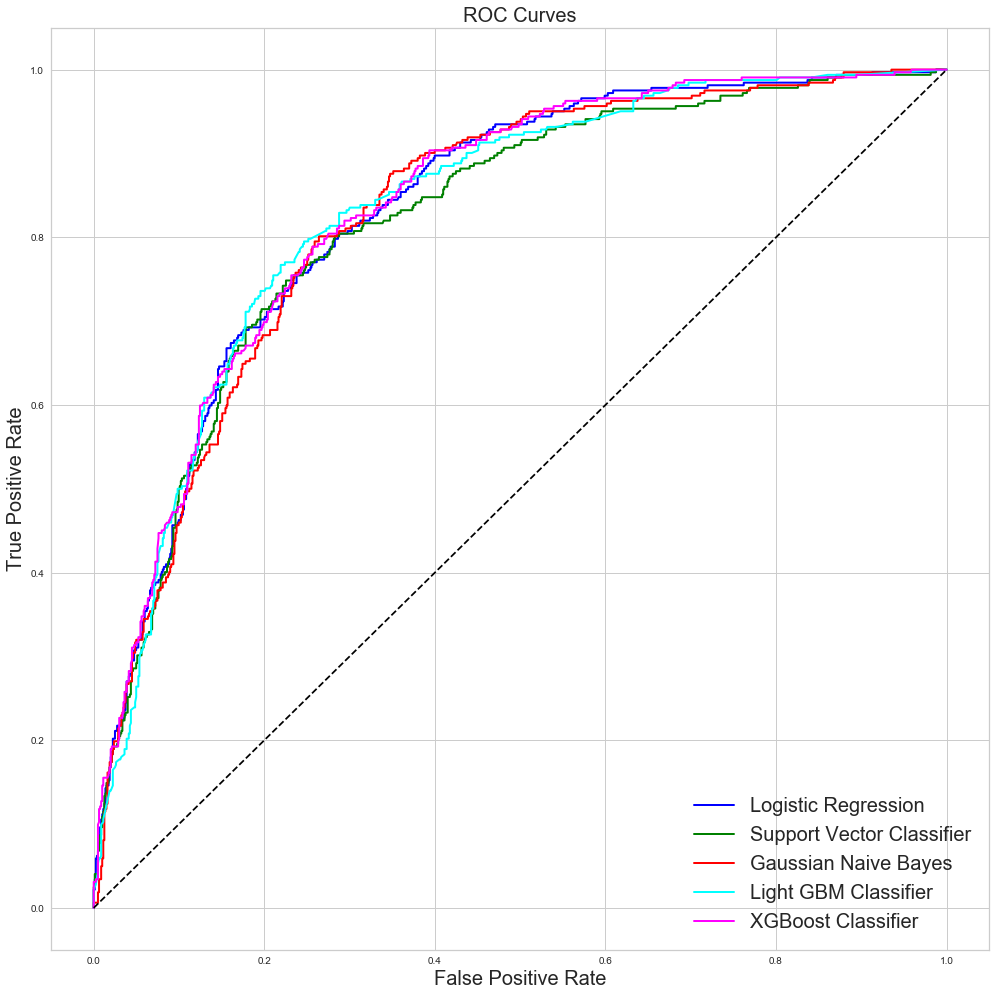

In [1131]:
plot_comparison_roc(best_models,
                    test_x = val_X ,
                    test_y = val_Y,
                   )

In [1025]:
important_features

['Contract_Two year',
 'tenure',
 'PhoneService_Yes',
 'Contract_One year',
 'tenure_bin_Tenure_60+',
 'Churn_Yes']

In [1078]:
# sns.pairplot(complete[important_features])

In [1031]:
# sns.pairplot(complete)

average event rate per most important features

In [1035]:
mean_contract1 = complete.groupby(['Contract_One year']).mean()

In [1036]:
mean_contract1

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents_Yes,PhoneService_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes
Contract_One year,,,,,,,,,,,,,,,,,,,,,
0,29.866547,64.723759,2084.373237,0.096223,0.422842,0.459892,0.208094,0.303058,0.201978,0.362950,...,0.282194,0.903777,0.263129,0.324281,0.318705,0.267626,0.368885,0.372122,0.605935,0.306295
1,42.073370,65.079416,3034.683084,0.098505,0.418478,0.366168,0.246603,0.000000,0.270380,0.235734,...,0.360054,0.901495,0.375000,0.422554,0.438859,0.375000,0.442935,0.449728,0.542799,0.112772


In [1033]:
mean_contract2 = complete.groupby(['Contract_Two year']).mean()

In [1034]:
mean_contract2

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents_Yes,PhoneService_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes
Contract_Two year,,,,,,,,,,,,,,,,,,,,,
0,24.653825,66.035356,1827.737984,0.097438,0.392370,0.498784,0.165887,0.275295,0.175987,0.410885,...,0.246680,0.902562,0.23789,0.315130,0.299794,0.228726,0.364690,0.367683,0.633065,0.340565
1,57.071810,60.872374,3728.933947,0.094362,0.515727,0.254599,0.375668,0.000000,0.344214,0.099703,...,0.462908,0.905638,0.44095,0.439169,0.483680,0.484866,0.446884,0.454006,0.464688,0.028487


In [1072]:
monthly = complete[((complete['Contract_One year'] == 0) & (complete['Contract_Two year'] == 0))]

In [1074]:
mean_monthly = monthly.mean().to_frame().transpose()

In [1075]:
mean_monthly

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),...,Dependents_Yes,PhoneService_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,Churn_Yes
0,18.036645,66.39849,1369.254581,0.097032,0.382452,0.549161,0.135226,0.0,0.0,0.140129,...,0.203613,0.902968,0.185806,0.274323,0.246968,0.173161,0.334968,0.336516,0.667355,0.427097


In [1076]:
complete.mean()

tenure                                     32.421786
MonthlyCharges                             64.798208
TotalCharges                             2283.300441
MultipleLines_No phone service              0.096701
MultipleLines_Yes                           0.421928
InternetService_Fiber optic                 0.440273
InternetService_No                          0.216155
Contract_One year                           0.209329
Contract_Two year                           0.239619
PaymentMethod_Credit card (automatic)       0.216297
PaymentMethod_Electronic check              0.336320
PaymentMethod_Mailed check                  0.228100
tenure_bin_Tenure_12_to_24                  0.145620
tenure_bin_Tenure_24_to_48                  0.226678
tenure_bin_Tenure_48_to_60                  0.118316
tenure_bin_Tenure_60+                       0.200085
gender_Male                                 0.504693
SeniorCitizen_1                             0.162400
Partner_Yes                                 0.

In [1106]:
#cusomer attrition in tenure groups
tg_ch  =  df_only_churn["tenure_bin"].value_counts().reset_index()
tg_ch.columns  = ["tenure_bin","count"]
tg_nch =  df_not_churn["tenure_bin"].value_counts().reset_index()
tg_nch.columns = ["tenure_bin","count"]

#bar - churn
trace1 = go.Bar(x = tg_ch["tenure_bin"]  , y = tg_ch["count"],
                name = "Churn",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = 1)

#bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_bin"] , y = tg_nch["count"],
                name = "Non Churn",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = 1)

layout = go.Layout(dict(title = "Customer Attrition by Tenure Bins",
                        plot_bgcolor  = "rgb(255,255,255)",
                        paper_bgcolor = "rgb(255,255,255)",
                        xaxis = dict(
                                    gridcolor = 'rgb(255, 255, 255)',
                                     title = "Tenure bin",
                                     zerolinewidth = 1,ticklen = 5,gridwidth = 2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig, filename =  'jupyter-table2')